In [184]:
# import libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
from sklearn.model_selection import train_test_split

# tree models
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Data Prep.

In [317]:
# uber sample data set
path = '../data'
data = pd.read_csv(path+'/data.csv')


In [318]:
new_columns = [c.lower() for c in data.columns]
data.columns = new_columns

In [322]:
'''
the haversine formula assumes the earth is a sphere, which results in errors of up to about 0.5% (according to help(geopy.distance)). 
The Vincenty distance uses more accurate ellipsoidal models, such as WGS-84, and is implemented in geopy. For example,
'''

data["weatherconditions"] = data["weatherconditions"].apply(lambda x: x.replace("conditions ", ""))
data["time_taken(min)"] = data["time_taken(min)"].apply(lambda x: x.replace("(min)", ""))  #.astype('int32')
# data["distance"] = geopy.distance.geodesic(coords_1, coords_2)

In [323]:
data["restaurant_coord"] = data.apply(lambda x: (x["restaurant_latitude"], x["restaurant_longitude"]), axis=1)
data["delivery_coord"] = data.apply(lambda x: (x["delivery_location_latitude"], x["delivery_location_longitude"]), axis=1)
data["distance_m"] = data.apply(lambda x: geopy.distance.geodesic(x["restaurant_coord"], x["delivery_coord"]).m, axis=1)
data["type_of_vehicle_cd"] = data["type_of_vehicle"].astype('category').cat.codes  #.astype('category')
data = data.replace('NaN ', pd.NA).dropna()
# data.dropna(inplace=True)


In [324]:
#zip the number and name together into a dictionary
label_dict = dict(zip(data["type_of_vehicle_cd"], data["type_of_vehicle"]))
label_dict

{1: 'motorcycle ', 2: 'scooter ', 0: 'electric_scooter '}

In [325]:
data["type_of_vehicle"].value_counts()

type_of_vehicle
motorcycle           24300
scooter              13723
electric_scooter      3345
Name: count, dtype: int64

In [326]:
len(data)

41368

In [327]:
data.head(10)

,id,delivery_person_id,delivery_person_age,delivery_person_ratings,restaurant_latitude,restaurant_longitude,delivery_location_latitude,delivery_location_longitude,order_date,time_orderd,...,type_of_order,type_of_vehicle,multiple_deliveries,festival,city,time_taken(min),restaurant_coord,delivery_coord,distance_m,type_of_vehicle_cd
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,...,Snack,motorcycle,0,No,Urban,24,"(22.745049, 75.892471)","(22.765049, 75.912471)",3020.736643,1
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,...,Snack,scooter,1,No,Metropolitian,33,"(12.913041, 77.683237)","(13.043041, 77.813237)",20143.736910,2
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,...,Drinks,motorcycle,1,No,Urban,26,"(12.914264, 77.6784)","(12.924264, 77.6884)",1549.692932,1
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,...,Buffet,motorcycle,1,No,Metropolitian,21,"(11.003669, 76.976494)","(11.053669, 77.026494)",7774.496620,1
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,...,Snack,scooter,1,No,Metropolitian,30,"(12.972793, 80.249982)","(13.012793, 80.289982)",6197.897917,2
5,0x9bb4,HYDRES09DEL03,22,4.8,17.431668,78.408321,17.461668,78.438321,11-03-2022,21:20:00,...,Buffet,motorcycle,1,No,Urban,26,"(17.431668, 78.408321)","(17.461668, 78.438321)",4602.205336,1
6,0x95b4,RANCHIRES15DEL01,33,4.7,23.369746,85.339820,23.479746,85.449820,04-03-2022,19:15:00,...,Meal,scooter,1,No,Metropolitian,40,"(23.369746, 85.33982)","(23.479746, 85.44982)",16576.886807,2
7,0x9eb2,MYSRES15DEL02,35,4.6,12.352058,76.606650,12.482058,76.736650,14-03-2022,17:25:00,...,Meal,motorcycle,1,No,Metropolitian,32,"(12.352058, 76.60665)","(12.482058, 76.73665)",20164.987512,1
8,0x1102,HYDRES05DEL02,22,4.8,17.433809,78.386744,17.563809,78.516744,20-03-2022,20:55:00,...,Buffet,motorcycle,1,No,Metropolitian,34,"(17.433809, 78.386744)","(17.563809, 78.516744)",19940.219402,1
9,0xcdcd,DEHRES17DEL01,36,4.2,30.327968,78.046106,30.397968,78.116106,12-02-2022,21:55:00,...,Snack,motorcycle,3,No,Metropolitian,46,"(30.327968, 78.046106)","(30.397968, 78.116106)",10271.464023,1


# Regression

In [328]:
features = ["distance_m", "delivery_person_age", "delivery_person_ratings"]
target = 'time_taken(min)'
labels = data[target].unique().tolist()
labels = [str(i) for i in labels]

X = data[features]
y = data[target]  #.values.reshape(-1)

seed = 42


In [335]:
# Train-Test-Validation Split: 6:2:2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33094, 3), (8274, 3), (33094,), (8274,))

In [336]:
tree_reg = DecisionTreeRegressor(max_depth=3, random_state=seed)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [338]:
# # evaluate
# acc_train = tree_reg.score(X_train, y_train)
# print("Accuracy on train = %0.4f " % acc_train)
# acc_test = tree_reg.score(X_test, y_test)
# print("Accuracy on test = %0.4f " % acc_test)

In [342]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred_train = tree_reg.predict(X_train)
y_pred_test = tree_reg.predict(X_test)

# # Predicting R2 Score 
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_pred_train, y_train) 
mae_test = mean_absolute_error(y_pred_test, y_test) 

print('R2_score(train): ', r2_score_train)
print('R2_score(validation): ', r2_score_test)
print("MAE(train): ", mae_train)
print("MAE(validation): ", mae_test)

R2_score(train):  0.37515479532463436
R2_score(validation):  0.364430045733131
MAE(train):  5.84568401996835
MAE(validation):  5.893303531681788


In [358]:
rf_reg = RandomForestRegressor(n_estimators=1000,  #number of decision trees (base estimator) in the Random Forest Regressor 
                                max_depth=7,  #maximum depth (number of levels) allowed in each decision tree
                                min_samples_split=3,  # minimum number of samples (observations) required for a split in a decision tree
                                min_samples_leaf=3,  # minimum number of samples (observations) required for a leaf node in a decision tree
                                random_state=seed)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=3,
                      n_estimators=1000, random_state=42)

In [359]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

# # Predicting R2 Score 
r2_score_train = r2_score(y_train, y_pred_train)
r2_score_test = r2_score(y_test, y_pred_test)

mae_train = mean_absolute_error(y_pred_train, y_train) 
mae_test = mean_absolute_error(y_pred_test, y_test) 

print('R2_score(train): ', r2_score_train)
print('R2_score(validation): ', r2_score_test)
print("MAE(train): ", mae_train)
print("MAE(validation): ", mae_test)

R2_score(train):  0.41156508602674413
R2_score(validation):  0.38334100952653305
MAE(train):  5.627683670539533
MAE(validation):  5.765759559731883


# Classification

In [360]:
features = ["distance_m","time_taken(min)"]
target = 'type_of_vehicle_cd'
labels = data[target].unique().tolist()
labels = [str(i) for i in labels]

X = data[features]
y = data[target]  #.values.reshape(-1)

seed = 42


In [361]:
# Train-Test-Validation Split: 6:2:2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=seed)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed) # 0.25 x 0.8 = 0.2
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((33094, 2), (8274, 2), (33094,), (8274,))

# Decision Tree Clf.

In [208]:
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=seed)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [209]:
# evaluate
acc_train = tree_clf.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)
acc_test = tree_clf.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.5816 
Accuracy on test = 0.5815 


In [210]:
# display confusion matrix
from sklearn.metrics import confusion_matrix
y_preds = tree_clf.predict(X_test)
cm = confusion_matrix(y_test, y_preds)
print("Confusion matrix: ")
print(cm)

Confusion matrix: 
[[   0    0   13    1]
 [   0    0  738   25]
 [   0    0 5187  100]
 [   0    0 2939  116]]


In [211]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_preds, target_names=[label_dict[int(i)] for i in labels], zero_division=0))


Classification Report

                   precision    recall  f1-score   support

      motorcycle        0.00      0.00      0.00        14
         scooter        0.00      0.00      0.00       763
electric_scooter        0.58      0.98      0.73      5287
         bicycle        0.48      0.04      0.07      3055

         accuracy                           0.58      9119
        macro avg       0.27      0.25      0.20      9119
     weighted avg       0.50      0.58      0.45      9119


In [212]:
pd.Series(tree_clf.predict(X_test)).value_counts(normalize=True)

2    0.973462
3    0.026538
Name: proportion, dtype: float64

In [213]:
pd.Series(y_test).value_counts(normalize=True)

type_of_vehicle_cd
2    0.579778
3    0.335015
1    0.083671
0    0.001535
Name: proportion, dtype: float64

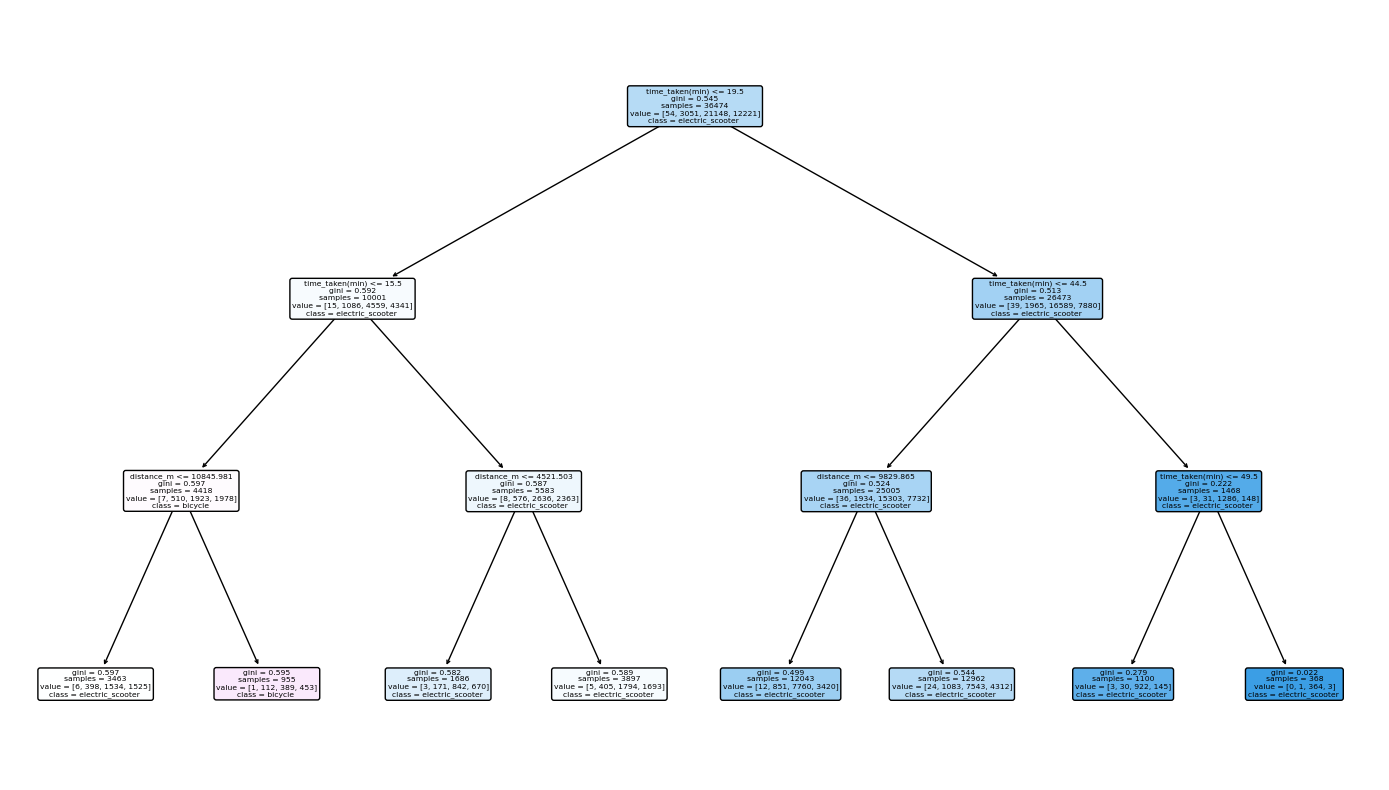

In [214]:
#plt the figure, setting a black background
plt.figure(figsize=(14,8),tight_layout=True)
#create the tree plot
a = tree.plot_tree(tree_clf,
                   #use the feature names stored
                   feature_names = features,
                   #use the class names stored
                   class_names = [label_dict[int(i)] for i in labels],
                   rounded = True,
                   filled = True,
                   # fontsize=10
                   )
#show the plot
plt.show()

# Random Forest Clf.

In [435]:
# rf_clf = RandomForestClassifier(n_estimators=2000,  #number of decision trees (base estimator) in the Random Forest Regressor 
#                                 max_depth=30,  #maximum depth (number of levels) allowed in each decision tree
#                                 min_samples_split=2,  # minimum number of samples (observations) required for a split in a decision tree
#                                 min_samples_leaf=2,  # minimum number of samples (observations) required for a leaf node in a decision tree
#                                 # class_weight='balanced',  #the classes will be weighted inversely proportional to how frequently they appear in the data.
#                                 # class_weight={0:5, 1:5, 2:1, 3:2},  #custom class wieghts to give more importance to minority classes 
#                                 random_state=seed)
rf_clf = RandomForestClassifier(n_estimators=200,
                                class_weight='balanced',  #the classes will be weighted inversely proportional to how frequently they appear in the data.                                
                                max_depth=3)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, n_estimators=200)

In [436]:
# evaluate
acc_train = rf_clf.score(X_train, y_train)
print("Accuracy on train = %0.4f " % acc_train)
acc_test = rf_clf.score(X_test, y_test)
print("Accuracy on test = %0.4f " % acc_test)

Accuracy on train = 0.4903 
Accuracy on test = 0.4784 


In [437]:
pd.Series(rf_clf.predict(X_test)).value_counts(normalize=True)

1    0.647692
0    0.256103
2    0.096205
Name: proportion, dtype: float64

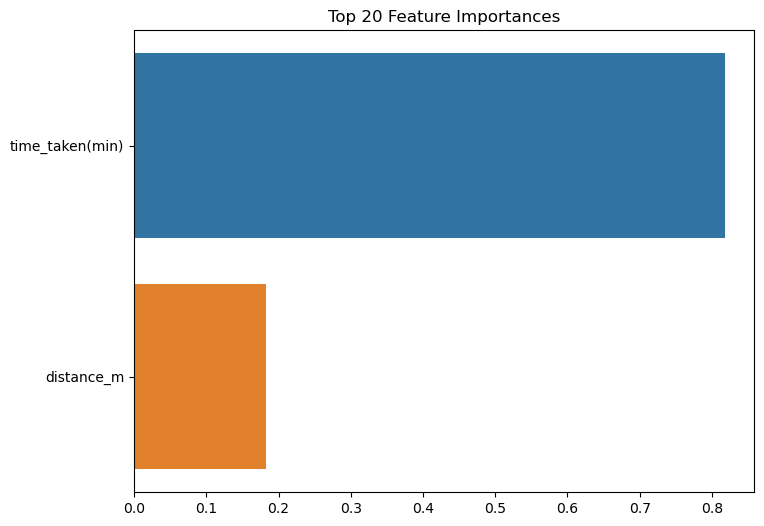

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()